In [1]:
import os 
import time

import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import scatter_matrix

import sklearn
from sklearn.model_selection import KFold, cross_validate, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold # Split data
from sklearn.metrics import accuracy_score # Compute accuracy
from sklearn.metrics import f1_score
from sklearn.preprocessing import Normalizer, MinMaxScaler

from sklearn.decomposition import PCA 

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import pickle
import random
from tqdm import tqdm # Progress Bar

import tensorflow as tf
tf.test.gpu_device_name()

from sklearn.preprocessing import LabelEncoder


# Options
pd.set_option("display.precision", 2)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Load Data

Load data which contains original features and synthetically generated features.

In [2]:
all_data = pd.read_csv("../Data/final_preprocessed_data.csv")

In [3]:
all_data.head()

,track_id,title,title.1,location,name,bit_rate,genre_id,chroma_cens,chroma_cens.1,chroma_cens.2,chroma_cens.3,chroma_cens.4,chroma_cens.5,chroma_cens.6,chroma_cens.7,chroma_cens.8,chroma_cens.9,chroma_cens.10,chroma_cens.11,chroma_cens.12,chroma_cens.13,chroma_cens.14,chroma_cens.15,chroma_cens.16,chroma_cens.17,chroma_cens.18,chroma_cens.19,chroma_cens.20,chroma_cens.21,chroma_cens.22,chroma_cens.23,chroma_cens.24,chroma_cens.25,chroma_cens.26,chroma_cens.27,chroma_cens.28,chroma_cens.29,chroma_cens.30,chroma_cens.31,chroma_cens.32,chroma_cens.33,chroma_cens.34,chroma_cens.35,chroma_cens.36,chroma_cens.37,chroma_cens.38,chroma_cens.39,chroma_cens.40,chroma_cens.41,chroma_cens.42,chroma_cens.43,chroma_cens.44,chroma_cens.45,chroma_cens.46,chroma_cens.47,chroma_cens.48,chroma_cens.49,chroma_cens.50,chroma_cens.51,chroma_cens.52,chroma_cens.53,chroma_cens.54,chroma_cens.55,chroma_cens.56,chroma_cens.57,chroma_cens.58,chroma_cens.59,chroma_cens.60,chroma_cens.61,chroma_cens.62,chroma_cens.63,chroma_cens.64,chroma_cens.65,chroma_cens.66,chroma_cens.67,chroma_cens.68,chroma_cens.69,chroma_cens.70,chroma_cens.71,chroma_cens.72,chroma_cens.73,chroma_cens.74,chroma_cens.75,chroma_cens.76,chroma_cens.77,chroma_cens.78,chroma_cens.79,chroma_cens.80,chroma_cens.81,chroma_cens.82,chroma_cens.83,chroma_cqt,chroma_cqt.1,chroma_cqt.2,chroma_cqt.3,chroma_cqt.4,chroma_cqt.5,chroma_cqt.6,chroma_cqt.7,chroma_cqt.8,chroma_cqt.9,chroma_cqt.10,chroma_cqt.11,chroma_cqt.12,chroma_cqt.13,chroma_cqt.14,chroma_cqt.15,chroma_cqt.16,chroma_cqt.17,chroma_cqt.18,chroma_cqt.19,chroma_cqt.20,chroma_cqt.21,chroma_cqt.22,chroma_cqt.23,chroma_cqt.24,chroma_cqt.25,chroma_cqt.26,chroma_cqt.27,chroma_cqt.28,chroma_cqt.29,chroma_cqt.30,chroma_cqt.31,chroma_cqt.32,chroma_cqt.33,chroma_cqt.34,chroma_cqt.35,chroma_cqt.36,chroma_cqt.37,chroma_cqt.38,chroma_cqt.39,chroma_cqt.40,chroma_cqt.41,chroma_cqt.42,chroma_cqt.43,chroma_cqt.44,chroma_cqt.45,chroma_cqt.46,chroma_cqt.47,chroma_cqt.48,chroma_cqt.49,chroma_cqt.50,chroma_cqt.51,chroma_cqt.52,chroma_cqt.53,chroma_cqt.54,chroma_cqt.55,chroma_cqt.56,chroma_cqt.57,chroma_cqt.58,chroma_cqt.59,chroma_cqt.60,chroma_cqt.61,chroma_cqt.62,chroma_cqt.63,chroma_cqt.64,chroma_cqt.65,chroma_cqt.66,chroma_cqt.67,chroma_cqt.68,chroma_cqt.69,chroma_cqt.70,chroma_cqt.71,chroma_cqt.72,chroma_cqt.73,chroma_cqt.74,chroma_cqt.75,chroma_cqt.76,chroma_cqt.77,chroma_cqt.78,chroma_cqt.79,chroma_cqt.80,chroma_cqt.81,chroma_cqt.82,chroma_cqt.83,chroma_stft,chroma_stft.1,chroma_stft.2,chroma_stft.3,chroma_stft.4,chroma_stft.5,chroma_stft.6,chroma_stft.7,chroma_stft.8,chroma_stft.9,chroma_stft.10,chroma_stft.11,chroma_stft.12,chroma_stft.13,chroma_stft.14,chroma_stft.15,chroma_stft.16,chroma_stft.17,chroma_stft.18,chroma_stft.19,chroma_stft.20,chroma_stft.21,chroma_stft.22,chroma_stft.23,chroma_stft.24,chroma_stft.25,chroma_stft.26,chroma_stft.27,chroma_stft.28,chroma_stft.29,chroma_stft.30,chroma_stft.31,chroma_stft.32,chroma_stft.33,chroma_stft.34,chroma_stft.35,chroma_stft.36,chroma_stft.37,chroma_stft.38,chroma_stft.39,chroma_stft.40,chroma_stft.41,chroma_stft.42,chroma_stft.43,chroma_stft.44,chroma_stft.45,chroma_stft.46,chroma_stft.47,chroma_stft.48,chroma_stft.49,chroma_stft.50,chroma_stft.51,chroma_stft.52,chroma_stft.53,chroma_stft.54,chroma_stft.55,chroma_stft.56,chroma_stft.57,chroma_stft.58,chroma_stft.59,chroma_stft.60,chroma_stft.61,chroma_stft.62,chroma_stft.63,chroma_stft.64,chroma_stft.65,chroma_stft.66,chroma_stft.67,chroma_stft.68,chroma_stft.69,chroma_stft.70,chroma_stft.71,chroma_stft.72,chroma_stft.73,chroma_stft.74,chroma_stft.75,chroma_stft.76,chroma_stft.77,chroma_stft.78,chroma_stft.79,chroma_stft.80,chroma_stft.81,chroma_stft.82,chroma_stft.83,mfcc,mfcc.1,mfcc.2,mfcc.3,mfcc.4,mfcc.5,mfcc.6,mfcc.7,mfcc.8,mfcc.9,mfcc.10,mfcc.11,mfcc.12,mfcc.13,mfcc.14,mfcc.15,mfcc.16,mfcc.17,mfcc.18,mfcc.19,mfcc.20,mfcc.21,mfcc.22,mfcc.23,mfcc.24,mfcc.25,mfcc.26,mfcc.27,mfcc.28,mfcc.29,mfcc.30,mfcc.31,mfcc.32,mfcc.33,mfcc.34,mfcc.35,mfcc.36,

In [4]:
# Split into features and label
labels = all_data['genre_id']
features_numeric = all_data.drop(columns=["track_id", "genre_id"])

In [5]:
print(features_numeric.shape)
features_numeric.describe()

(91901, 523)


,title,title.1,location,name,bit_rate,chroma_cens,chroma_cens.1,chroma_cens.2,chroma_cens.3,chroma_cens.4,chroma_cens.5,chroma_cens.6,chroma_cens.7,chroma_cens.8,chroma_cens.9,chroma_cens.10,chroma_cens.11,chroma_cens.12,chroma_cens.13,chroma_cens.14,chroma_cens.15,chroma_cens.16,chroma_cens.17,chroma_cens.18,chroma_cens.19,chroma_cens.20,chroma_cens.21,chroma_cens.22,chroma_cens.23,chroma_cens.24,chroma_cens.25,chroma_cens.26,chroma_cens.27,chroma_cens.28,chroma_cens.29,chroma_cens.30,chroma_cens.31,chroma_cens.32,chroma_cens.33,chroma_cens.34,chroma_cens.35,chroma_cens.36,chroma_cens.37,chroma_cens.38,chroma_cens.39,chroma_cens.40,chroma_cens.41,chroma_cens.42,chroma_cens.43,chroma_cens.44,chroma_cens.45,chroma_cens.46,chroma_cens.47,chroma_cens.48,chroma_cens.49,chroma_cens.50,chroma_cens.51,chroma_cens.52,chroma_cens.53,chroma_cens.54,chroma_cens.55,chroma_cens.56,chroma_cens.57,chroma_cens.58,chroma_cens.59,chroma_cens.60,chroma_cens.61,chroma_cens.62,chroma_cens.63,chroma_cens.64,chroma_cens.65,chroma_cens.66,chroma_cens.67,chroma_cens.68,chroma_cens.69,chroma_cens.70,chroma_cens.71,chroma_cens.72,chroma_cens.73,chroma_cens.74,chroma_cens.75,chroma_cens.76,chroma_cens.77,chroma_cens.78,chroma_cens.79,chroma_cens.80,chroma_cens.81,chroma_cens.82,chroma_cens.83,chroma_cqt,chroma_cqt.1,chroma_cqt.2,chroma_cqt.3,chroma_cqt.4,chroma_cqt.5,chroma_cqt.6,chroma_cqt.7,chroma_cqt.8,chroma_cqt.9,chroma_cqt.10,chroma_cqt.11,chroma_cqt.12,chroma_cqt.13,chroma_cqt.14,chroma_cqt.15,chroma_cqt.16,chroma_cqt.17,chroma_cqt.18,chroma_cqt.19,chroma_cqt.20,chroma_cqt.21,chroma_cqt.22,chroma_cqt.23,chroma_cqt.24,chroma_cqt.25,chroma_cqt.26,chroma_cqt.27,chroma_cqt.28,chroma_cqt.29,chroma_cqt.30,chroma_cqt.31,chroma_cqt.32,chroma_cqt.33,chroma_cqt.34,chroma_cqt.35,chroma_cqt.36,chroma_cqt.37,chroma_cqt.38,chroma_cqt.39,chroma_cqt.40,chroma_cqt.41,chroma_cqt.42,chroma_cqt.43,chroma_cqt.44,chroma_cqt.45,chroma_cqt.46,chroma_cqt.47,chroma_cqt.48,chroma_cqt.49,chroma_cqt.50,chroma_cqt.51,chroma_cqt.52,chroma_cqt.53,chroma_cqt.54,chroma_cqt.55,chroma_cqt.56,chroma_cqt.57,chroma_cqt.58,chroma_cqt.59,chroma_cqt.60,chroma_cqt.61,chroma_cqt.62,chroma_cqt.63,chroma_cqt.64,chroma_cqt.65,chroma_cqt.66,chroma_cqt.67,chroma_cqt.68,chroma_cqt.69,chroma_cqt.70,chroma_cqt.71,chroma_cqt.72,chroma_cqt.73,chroma_cqt.74,chroma_cqt.75,chroma_cqt.76,chroma_cqt.77,chroma_cqt.78,chroma_cqt.79,chroma_cqt.80,chroma_cqt.81,chroma_cqt.82,chroma_cqt.83,chroma_stft,chroma_stft.1,chroma_stft.2,chroma_stft.3,chroma_stft.4,chroma_stft.5,chroma_stft.6,chroma_stft.7,chroma_stft.8,chroma_stft.9,chroma_stft.10,chroma_stft.11,chroma_stft.12,chroma_stft.13,chroma_stft.14,chroma_stft.15,chroma_stft.16,chroma_stft.17,chroma_stft.18,chroma_stft.19,chroma_stft.20,chroma_stft.21,chroma_stft.22,chroma_stft.23,chroma_stft.24,chroma_stft.25,chroma_stft.26,chroma_stft.27,chroma_stft.28,chroma_stft.29,chroma_stft.30,chroma_stft.31,chroma_stft.32,chroma_stft.33,chroma_stft.34,chroma_stft.35,chroma_stft.36,chroma_stft.37,chroma_stft.38,chroma_stft.39,chroma_stft.40,chroma_stft.41,chroma_stft.42,chroma_stft.43,chroma_stft.44,chroma_stft.45,chroma_stft.46,chroma_stft.47,chroma_stft.48,chroma_stft.49,chroma_stft.50,chroma_stft.51,chroma_stft.52,chroma_stft.53,chroma_stft.54,chroma_stft.55,chroma_stft.56,chroma_stft.57,chroma_stft.58,chroma_stft.59,chroma_stft.60,chroma_stft.61,chroma_stft.62,chroma_stft.63,chroma_stft.64,chroma_stft.65,chroma_stft.66,chroma_stft.67,chroma_stft.68,chroma_stft.69,chroma_stft.70,chroma_stft.71,chroma_stft.72,chroma_stft.73,chroma_stft.74,chroma_stft.75,chroma_stft.76,chroma_stft.77,chroma_stft.78,chroma_stft.79,chroma_stft.80,chroma_stft.81,chroma_stft.82,chroma_stft.83,mfcc,mfcc.1,mfcc.2,mfcc.3,mfcc.4,mfcc.5,mfcc.6,mfcc.7,mfcc.8,mfcc.9,mfcc.10,mfcc.11,mfcc.12,mfcc.13,mfcc.14,mfcc.15,mfcc.16,mfcc.17,mfcc.18,mfcc.19,mfcc.20,mfcc.21,mfcc.22,mfcc.23,mfcc.24,mfcc.25,mfcc.26,mfcc.27,mfcc.28,mfcc.29,mfcc.30,mfcc.31,mfcc.32,mfcc.33,mfcc.34,mfcc.35,mfcc.36,mfcc.37,mfcc.38,mf

In [6]:
# Normalize features
colNames = features_numeric.columns
norm = MinMaxScaler(copy=False)

features_numeric[colNames] = norm.fit_transform(features_numeric[colNames]) 

In [7]:
features_numeric.describe()

,title,title.1,location,name,bit_rate,chroma_cens,chroma_cens.1,chroma_cens.2,chroma_cens.3,chroma_cens.4,chroma_cens.5,chroma_cens.6,chroma_cens.7,chroma_cens.8,chroma_cens.9,chroma_cens.10,chroma_cens.11,chroma_cens.12,chroma_cens.13,chroma_cens.14,chroma_cens.15,chroma_cens.16,chroma_cens.17,chroma_cens.18,chroma_cens.19,chroma_cens.20,chroma_cens.21,chroma_cens.22,chroma_cens.23,chroma_cens.24,chroma_cens.25,chroma_cens.26,chroma_cens.27,chroma_cens.28,chroma_cens.29,chroma_cens.30,chroma_cens.31,chroma_cens.32,chroma_cens.33,chroma_cens.34,chroma_cens.35,chroma_cens.36,chroma_cens.37,chroma_cens.38,chroma_cens.39,chroma_cens.40,chroma_cens.41,chroma_cens.42,chroma_cens.43,chroma_cens.44,chroma_cens.45,chroma_cens.46,chroma_cens.47,chroma_cens.48,chroma_cens.49,chroma_cens.50,chroma_cens.51,chroma_cens.52,chroma_cens.53,chroma_cens.54,chroma_cens.55,chroma_cens.56,chroma_cens.57,chroma_cens.58,chroma_cens.59,chroma_cens.60,chroma_cens.61,chroma_cens.62,chroma_cens.63,chroma_cens.64,chroma_cens.65,chroma_cens.66,chroma_cens.67,chroma_cens.68,chroma_cens.69,chroma_cens.70,chroma_cens.71,chroma_cens.72,chroma_cens.73,chroma_cens.74,chroma_cens.75,chroma_cens.76,chroma_cens.77,chroma_cens.78,chroma_cens.79,chroma_cens.80,chroma_cens.81,chroma_cens.82,chroma_cens.83,chroma_cqt,chroma_cqt.1,chroma_cqt.2,chroma_cqt.3,chroma_cqt.4,chroma_cqt.5,chroma_cqt.6,chroma_cqt.7,chroma_cqt.8,chroma_cqt.9,chroma_cqt.10,chroma_cqt.11,chroma_cqt.12,chroma_cqt.13,chroma_cqt.14,chroma_cqt.15,chroma_cqt.16,chroma_cqt.17,chroma_cqt.18,chroma_cqt.19,chroma_cqt.20,chroma_cqt.21,chroma_cqt.22,chroma_cqt.23,chroma_cqt.24,chroma_cqt.25,chroma_cqt.26,chroma_cqt.27,chroma_cqt.28,chroma_cqt.29,chroma_cqt.30,chroma_cqt.31,chroma_cqt.32,chroma_cqt.33,chroma_cqt.34,chroma_cqt.35,chroma_cqt.36,chroma_cqt.37,chroma_cqt.38,chroma_cqt.39,chroma_cqt.40,chroma_cqt.41,chroma_cqt.42,chroma_cqt.43,chroma_cqt.44,chroma_cqt.45,chroma_cqt.46,chroma_cqt.47,chroma_cqt.48,chroma_cqt.49,chroma_cqt.50,chroma_cqt.51,chroma_cqt.52,chroma_cqt.53,chroma_cqt.54,chroma_cqt.55,chroma_cqt.56,chroma_cqt.57,chroma_cqt.58,chroma_cqt.59,chroma_cqt.60,chroma_cqt.61,chroma_cqt.62,chroma_cqt.63,chroma_cqt.64,chroma_cqt.65,chroma_cqt.66,chroma_cqt.67,chroma_cqt.68,chroma_cqt.69,chroma_cqt.70,chroma_cqt.71,chroma_cqt.72,chroma_cqt.73,chroma_cqt.74,chroma_cqt.75,chroma_cqt.76,chroma_cqt.77,chroma_cqt.78,chroma_cqt.79,chroma_cqt.80,chroma_cqt.81,chroma_cqt.82,chroma_cqt.83,chroma_stft,chroma_stft.1,chroma_stft.2,chroma_stft.3,chroma_stft.4,chroma_stft.5,chroma_stft.6,chroma_stft.7,chroma_stft.8,chroma_stft.9,chroma_stft.10,chroma_stft.11,chroma_stft.12,chroma_stft.13,chroma_stft.14,chroma_stft.15,chroma_stft.16,chroma_stft.17,chroma_stft.18,chroma_stft.19,chroma_stft.20,chroma_stft.21,chroma_stft.22,chroma_stft.23,chroma_stft.24,chroma_stft.25,chroma_stft.26,chroma_stft.27,chroma_stft.28,chroma_stft.29,chroma_stft.30,chroma_stft.31,chroma_stft.32,chroma_stft.33,chroma_stft.34,chroma_stft.35,chroma_stft.36,chroma_stft.37,chroma_stft.38,chroma_stft.39,chroma_stft.40,chroma_stft.41,chroma_stft.42,chroma_stft.43,chroma_stft.44,chroma_stft.45,chroma_stft.46,chroma_stft.47,chroma_stft.48,chroma_stft.49,chroma_stft.50,chroma_stft.51,chroma_stft.52,chroma_stft.53,chroma_stft.54,chroma_stft.55,chroma_stft.56,chroma_stft.57,chroma_stft.58,chroma_stft.59,chroma_stft.60,chroma_stft.61,chroma_stft.62,chroma_stft.63,chroma_stft.64,chroma_stft.65,chroma_stft.66,chroma_stft.67,chroma_stft.68,chroma_stft.69,chroma_stft.70,chroma_stft.71,chroma_stft.72,chroma_stft.73,chroma_stft.74,chroma_stft.75,chroma_stft.76,chroma_stft.77,chroma_stft.78,chroma_stft.79,chroma_stft.80,chroma_stft.81,chroma_stft.82,chroma_stft.83,mfcc,mfcc.1,mfcc.2,mfcc.3,mfcc.4,mfcc.5,mfcc.6,mfcc.7,mfcc.8,mfcc.9,mfcc.10,mfcc.11,mfcc.12,mfcc.13,mfcc.14,mfcc.15,mfcc.16,mfcc.17,mfcc.18,mfcc.19,mfcc.20,mfcc.21,mfcc.22,mfcc.23,mfcc.24,mfcc.25,mfcc.26,mfcc.27,mfcc.28,mfcc.29,mfcc.30,mfcc.31,mfcc.32,mfcc.33,mfcc.34,mfcc.35,mfcc.36,mfcc.37,mfcc.38,mf

### Models

In [8]:
X_train, X_test_temp, y_train, y_test_temp = train_test_split(features_numeric, labels, test_size=0.85, random_state=1, stratify=labels)
X_train.shape, X_test_temp.shape

((13785, 523), (78116, 523))

In [9]:
X_test, X_test2, y_test, y_test2 = train_test_split(X_test_temp, y_test_temp, test_size=0.85, random_state=1, stratify=y_test_temp)
X_test.shape, X_test2.shape

((11717, 523), (66399, 523))

In [10]:
from collections import Counter

print(Counter(y_train))
print(Counter(y_test))

Counter({1.0: 2283, 38.0: 2153, 10.0: 2046, 32.0: 2014, 17.0: 1879, 25.0: 1348, 12.0: 1111, 21.0: 951})
Counter({1.0: 1941, 38.0: 1830, 10.0: 1739, 32.0: 1711, 17.0: 1597, 25.0: 1146, 12.0: 944, 21.0: 809})


In [11]:
def train_models_cv(X, y, metric):

    kf = StratifiedKFold(5, random_state=42, shuffle=True)

    # KNN
    knn_clf = KNeighborsClassifier(n_neighbors=10, weights='distance')
    
    start_time = time.time()
    scores_knn = cross_val_score(knn_clf, X, y, scoring=metric, cv=kf)  
    print("--- KNN: %s seconds ---" % (time.time() - start_time))
    print("KNN score: " + str(np.mean(scores_knn)))
    print("-----------------------------------\n")
    
    # NB
    nb_clf = GaussianNB()
    start_time = time.time()
    scores_nb = cross_val_score(nb_clf, X, y, scoring=metric, cv=kf)
    print("--- NB: %s seconds ---" % (time.time() - start_time))
    print("NB score: " + str(np.mean(scores_nb)))
    print("-----------------------------------\n")
    
    # Random forest
    rf_clf = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42)
    start_time = time.time()
    scores_rf = cross_val_score(rf_clf, X, y, scoring=metric, cv=kf)
    print("--- RF: %s seconds ---" % (time.time() - start_time))
    print("RF score: " + str(np.mean(scores_rf)))
    print("-----------------------------------\n")

    # SGD
    sgd_clf = SGDClassifier(max_iter=2000, loss='log')
    start_time = time.time()
    scores_sgd = cross_val_score(sgd_clf, X, y, scoring=metric, cv=kf)
    print("--- SGD: %s seconds ---" % (time.time() - start_time))
    print("SGD score: " + str(np.mean(scores_sgd)))
    print("-----------------------------------\n")

    # SVM
    svmRbf_clf = SVC(kernel='rbf', probability=True)
    start_time = time.time()
    scores_svm = cross_val_score(svmRbf_clf, X, y, scoring=metric, cv=kf)
    print("--- SVM (RBF): %s seconds ---" % (time.time() - start_time))
    print("SVM (RBF) score: " + str(np.mean(scores_svm)))
    print("-----------------------------------\n")
    
    # MLP
    mlp_clf = MLPClassifier(hidden_layer_sizes=(200, 50), max_iter=2000)
    start_time = time.time()
    scores_mlp = cross_val_score(mlp_clf, X, y, scoring=metric, cv=kf)
    print("--- MLP: %s seconds ---" % (time.time() - start_time))
    print("MLP score: " + str(np.mean(scores_mlp)))
    print("-----------------------------------\n")
    
    # Ensemble Classifier (Majority voting)
    ensemble = VotingClassifier(estimators=[
                                          ('knn', knn_clf), 
                                          ('rf', rf_clf),
                                          ('svmRbf', svmRbf_clf), 
                                          ('svmPoly', sgd_clf), 
                                          ('mlp', mlp_clf)],
                              voting='soft', 
                              weights=[1,1,1,1,1])
    start_time = time.time()
    scores_eclf = cross_val_score(ensemble, X, y, scoring=metric, cv=kf)
    print("--- Ensemble: %s seconds ---" % (time.time() - start_time))
    print("Ensemble score: " + str(np.mean(scores_eclf)))
    print("-----------------------------------\n")

    scores = { 
        'KNN'     : scores_knn, 
        'Naive Bayes'      : scores_nb,
        'Random Forest'      : scores_rf,
        'SVM (RBF kernel)'     : scores_svm,
        'SGD'     : scores_sgd,
        'MLP'     : scores_mlp, 
        'Ensemble (without NB)'    : scores_eclf
        
    }
    
    return scores 

In [12]:
scores = train_models_cv(X_train, y_train, 'accuracy')

--- KNN: 5.251225471496582 seconds ---
KNN score: 0.43656147986942334
-----------------------------------

--- NB: 1.5313830375671387 seconds ---
NB score: 0.29198404062386657
-----------------------------------

--- RF: 883.9843423366547 seconds ---
RF score: 0.45397170837867246
-----------------------------------

--- SGD: 49.04919791221619 seconds ---
SGD score: 0.3868697859992746
-----------------------------------

--- SVM (RBF): 1987.4455814361572 seconds ---
SVM (RBF) score: 0.4210373594486761
-----------------------------------

--- MLP: 397.42842388153076 seconds ---
MLP score: 0.42256075444323543
-----------------------------------

--- Ensemble: 3024.4664540290833 seconds ---
Ensemble score: 0.4663764961915125
-----------------------------------



In [13]:
scores

{'KNN': array([0.43960827, 0.42546246, 0.43634385, 0.43706928, 0.44432354]),
 'Naive Bayes': array([0.29706202, 0.29488575, 0.29561117, 0.27675009, 0.29561117]),
 'Random Forest': array([0.46100834, 0.46318462, 0.45484222, 0.45085238, 0.43997098]),
 'SVM (RBF kernel)': array([0.43017773, 0.42836416, 0.40660138, 0.42002176, 0.42002176]),
 'SGD': array([0.38193689, 0.40188611, 0.36815379, 0.40623867, 0.37613348]),
 'MLP': array([0.42727602, 0.42328618, 0.41059122, 0.434893  , 0.41675734]),
 'Ensemble (without NB)': array([0.48458469, 0.46572361, 0.46100834, 0.45629307, 0.46427276])}

In [14]:
def plot_score_comparison(scores, metric):
    """
    plot_score_comparison plots the score comparison of the K-Fold Cross Validation.
    We can visually compare the performance of each model.
    
    Input :  scores            Dictionary: {model name : list of scores for the model}
             metric            String: metric used
    
    Author: Conrad Pereira
    
    """
    fig = plt.figure(figsize=(10,6))
    fig.suptitle(metric + ' Score Comparison using K-Fold Cross-Validation')
    ax = fig.add_subplot(111)
    for i, (k, v) in enumerate(scores.items()):
        ax.scatter(i * np.ones(len(v)) + 1, v, label=k, alpha=0.5)
    for i in range(5):
        ax.plot(range(1,len(scores)+1), [scores[k][i] for k in scores.keys()], c='k', alpha=0.2)
    ax.boxplot(scores.values())
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.show()

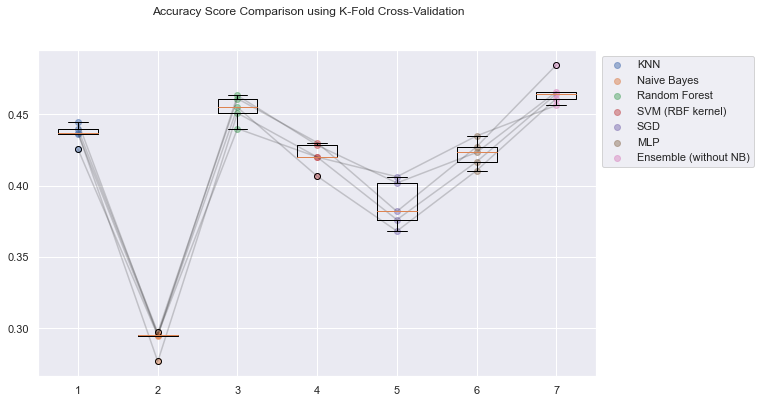

In [15]:
plot_score_comparison(scores, 'Accuracy')

In [16]:
for k, v in scores.items():
    print(k, np.mean(v), np.std(v))

KNN 0.43656147986942334 0.006213308119075483
Naive Bayes 0.29198404062386657 0.007649721480719078
Random Forest 0.45397170837867246 0.00825712195872742
SVM (RBF kernel) 0.4210373594486761 0.008338931009356015
SGD 0.3868697859992746 0.014768437210342145
MLP 0.42256075444323543 0.008388009877148942
Ensemble (without NB) 0.4663764961915125 0.009663156071292981
